# 1. Cargar Librerías

In [2]:
import warnings
import os
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datasets as ds
import math
import utils as ut
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Cargar los Dataset

In [51]:
movies_df = pd.read_csv("../data/raw/rotten_tomatoes_movies.csv")

movies_df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [4]:
critics_df = pd.read_csv("../data/raw/rotten_tomatoes_critic_reviews.csv")

critics_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [5]:
ut.analisis(movies_df)

Variables numéricas: ['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']
Variables no numéricas: ['rotten_tomatoes_link', 'movie_title', 'movie_info', 'critics_consensus', 'content_rating', 'genres', 'directors', 'authors', 'actors', 'original_release_date', 'streaming_release_date', 'production_company', 'tomatometer_status', 'audience_status']

Shape del dataset: (17712, 22)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus    

In [ ]:
ut.analisis(critics_df)

Variables numéricas: []
Variables no numéricas: ['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']

Shape del dataset: (1130017, 8)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB
None

Valores nulos por columna:
review_score            305936
review_cont

El dataset de películas, ***movies_df***, contiene 22 variables: 8 variable numéricas y 14 variables categóricas.

- rotten_tomatoes_link: Identificador o enlace único de la película en Rotten Tomatoes.
- movie_title: Título de la película.
- movie_info: Información general (sinopsis, detalles adicionales).
- critics_consensus: Resumen del consenso de los críticos.
- content_rating: Clasificación de la película (PG, R, etc.).
- genres: Género(s) de la película.
- directors: Director(es) de la película.
- authors: Críticos o autores asociados.
- actors: Actores principales.
- original_release_date: Fecha de estreno original.
- streaming_release_date: Fecha de estreno en plataformas digitales.
- runtime: Duración de la película (minutos).
- production_company: Productora responsable.
- tomatometer_status: Estado en el Tomatometer (Certified Fresh, Fresh, Rotten).
- tomatometer_rating: Puntuación promedio de críticos.
- tomatometer_count: Número de críticas registradas.
- audience_status: Estado de la audiencia (Upright/Spilled).
- audience_rating: Puntuación promedio de la audiencia.
- audience_count: Número de valoraciones de la audiencia.
- tomatometer_top_critics_count: Número de críticas de críticos top.
- tomatometer_fresh_critics_count: Cantidad de críticas positivas.
- tomatometer_rotten_critics_count: Cantidad de críticas negativas.


El dataset de reseñas, ***critics_df***, contiene 8 variables categóricas.

- rotten_tomatoes_link: Sirve como identificador de la película
- critic_name: Nombre del critico que comento la película
- top_critic: Valor booleano que aclara si el crítico es un crítico destacado o no
- publisher_name: nombre de la editorial para la que trabaja el crítico
- review_type: Determina si la reseña es positiva (fresh) o negativa (rotten)
- review_score: Puntaje proporcionado por el crítico
- review_date: Fecha de la reseña
- review_content: Contenido de la reseña

# 2. Exploración y limpieza

### 2.1 Comprensión de Datos

In [ ]:
print(f'El dataframe movies_df contiene {movies_df.shape[0]} filas y {movies_df.shape[1]} columnas.')

El dataframe movies_df contiene 17712 filas y 22 columnas.


In [ ]:
print(f'El dataframe critics_df contiene {critics_df.shape[0]} filas y {critics_df.shape[1]} columnas.')

El dataframe critics_df contiene 1130017 filas y 8 columnas.


### 2.2 Identificando nulos y duplicados

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [52]:
print(movies_df.isnull().sum())

print("Duplicados:", movies_df.duplicated().sum())

rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64
Duplicados: 0


In [53]:
movies_df = movies_df.drop_duplicates()

In [ ]:
critics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


In [8]:
print(critics_df.isnull().sum())

print("Duplicados:", critics_df.duplicated().sum())

rotten_tomatoes_link         0
critic_name              18529
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
review_content           65806
dtype: int64
Duplicados: 119471


In [9]:
critics_df = critics_df.drop_duplicates()
critics_df = critics_df.dropna(subset=['review_content'])

- Los nulos en el nombre del crítico se contrastan con el de publisher name asi que no es grave y se puede mantener
- El de review score se compensa con el de review type ya que determina si es util o no
- El de texto si es necesario arreglarlo para cuando se haga el NLP

### 2.3 Eliminar Información Irrelevante

In [11]:
critics = critics_df.copy().drop(columns=['review_date', 'review_score', 'critic_name'])

critics.head()

,rotten_tomatoes_link,top_critic,publisher_name,review_type,review_content
0,m/0814255,False,Urban Cinefile,Fresh,A fantasy adventure that fuses Greek mythology...
1,m/0814255,False,Urban Cinefile,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,False,FILMINK (Australia),Fresh,With a top-notch cast and dazzling special eff...
3,m/0814255,False,Sunday Mail (Australia),Fresh,Whether audiences will get behind The Lightnin...
4,m/0814255,True,Hollywood Reporter,Rotten,What's really lacking in The Lightning Thief i...


- La fecha no es relevante para el estudio.
- El puntaje tiene sus nulos, además de que ya hay un boolean que dice si la reseña será positiva o negativa.
- El nombre del crítico no hace falta si ya está el de la editorial que lo publica.

### 2.4 Crear Listas
Para poder hacer un mejor análisis de los datos, por cada columna que tenga varios valores, crearemos una lista de esos valores.

In [54]:
movies = movies_df.copy()

#### Géneros

In [55]:
movies["genres"] = movies["genres"].str.split(",")

movies["genres"] = movies["genres"].apply(
    lambda lst: [g.strip() for g in lst] if isinstance(lst, list) else []
)

#### Directores

In [56]:
movies["directors"] = movies["directors"].str.split(",")

movies["directors"] = movies["directors"].apply(
    lambda lst: [g.strip() for g in lst] if isinstance(lst, list) else []
)

#### Autores

In [57]:
movies["authors"] = movies["authors"].str.split(",")

movies["authors"] = movies["authors"].apply(
    lambda lst: [g.strip() for g in lst] if isinstance(lst, list) else []
)

#### Actores

In [58]:
movies["actors"] = movies["actors"].str.split(",")

movies["actors"] = movies["actors"].apply(
    lambda lst: [g.strip() for g in lst] if isinstance(lst, list) else []
)

### 2.5 Nuevos Datasets
Para las listas creadas previamente, crearemos nuevos datasets en el que cada fila corresponda a un elemento de la lista. Con estos datasets haremos un análisis univariante de esas variables.

In [16]:
movie_genre = movies.explode("genres").reset_index(drop=True)

movie_genre = movie_genre.rename(columns={"genres": "genre"})

movie_genre = movie_genre[["rotten_tomatoes_link", "genre"]].drop_duplicates()

In [ ]:
movie_genre.head()

,rotten_tomatoes_link,genre
0,m/0814255,Action & Adventure
1,m/0814255,Comedy
2,m/0814255,Drama
3,m/0814255,Science Fiction & Fantasy
4,m/0878835,Comedy


#### Directores

In [ ]:
movie_director = movies.explode("directors").reset_index(drop=True)

movie_director = movie_director.rename(columns={"directors": "director"})

movie_director = movie_director[["rotten_tomatoes_link", "director"]].drop_duplicates()

In [ ]:
movie_director.head()

,rotten_tomatoes_link,director
0,m/0814255,Chris Columbus
1,m/0878835,Nicole Holofcener
2,m/10,Blake Edwards
3,m/1000013-12_angry_men,Sidney Lumet
4,m/1000079-20000_leagues_under_the_sea,Richard Fleischer


#### Autores

In [ ]:
movie_author = movies.explode("authors").reset_index(drop=True)

movie_author = movie_author.rename(columns={"authors": "author"})

movie_author = movie_author[["rotten_tomatoes_link", "author"]].drop_duplicates()

In [ ]:
movie_author.head()

,rotten_tomatoes_link,author
0,m/0814255,Craig Titley
1,m/0814255,Chris Columbus
2,m/0814255,Rick Riordan
3,m/0878835,Nicole Holofcener
4,m/10,Blake Edwards


#### Actores

In [ ]:
movie_actor = movies.explode("actors").reset_index(drop=True)

movie_actor = movie_actor.rename(columns={"actors": "actor"})

movie_actor = movie_actor[["rotten_tomatoes_link", "actor"]].drop_duplicates()

In [ ]:
movie_actor.head()

,rotten_tomatoes_link,actor
0,m/0814255,Logan Lerman
1,m/0814255,Brandon T. Jackson
2,m/0814255,Alexandra Daddario
3,m/0814255,Jake Abel
4,m/0814255,Sean Bean


### 2.6 Transformamos las fechas en un formato que nos pueda servir para el análisis

In [59]:
movies["original_release_date"] = pd.to_datetime(movies["original_release_date"], errors="coerce")

#movies["release_timestamp"] = movies["original_release_date"].astype("int64") // 10**9

movies["release_year"] = movies['original_release_date'].dt.year

movies["release_year"] = movies["release_year"].fillna(0).astype(int)

In [60]:
movies["streaming_release_date"] = pd.to_datetime(movies["streaming_release_date"], errors="coerce")

#movies["streaming_timestamp"] = movies["streaming_release_date"].astype("int64") // 10**9

movies["streaming_release_year"] = movies['streaming_release_date'].dt.year

movies["streaming_release_year"] = movies["streaming_release_year"].fillna(0).astype(int)

In [61]:
movies.drop(columns=["original_release_date", "streaming_release_date"], inplace=True)

## 3. Análisis Univariante

### 3.1 Variables Numéricas

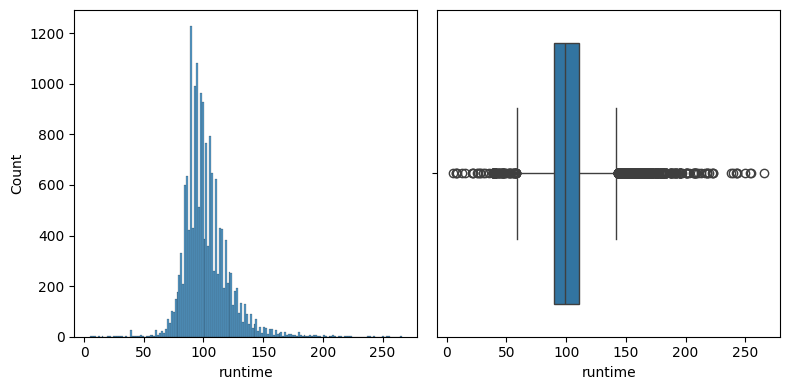

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# runtime
sns.histplot(ax = axis[0], data = movies, x = "runtime")
sns.boxplot(ax = axis[1], data = movies, x = "runtime")

plt.tight_layout()
plt.show()

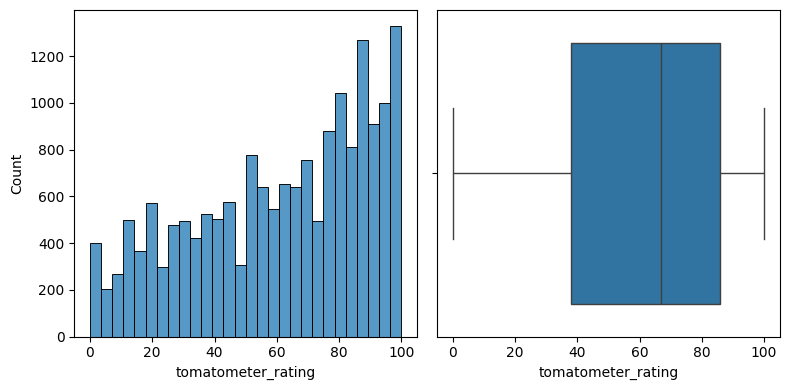

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# tomatometer_rating
sns.histplot(ax = axis[0], data = movies, x = "tomatometer_rating")
sns.boxplot(ax = axis[1], data = movies, x = "tomatometer_rating")

plt.tight_layout()
plt.show()

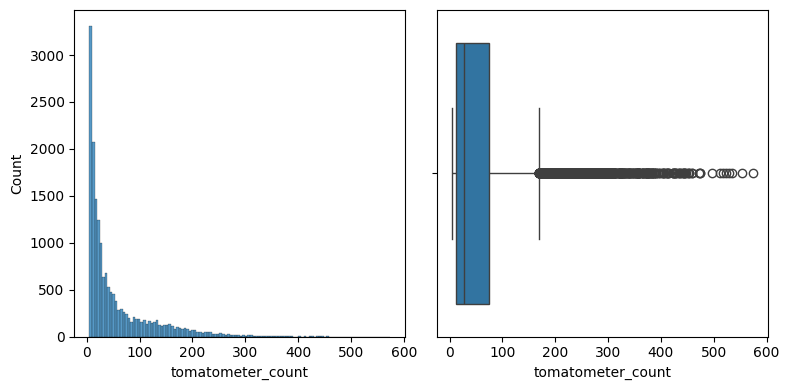

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# tomatometer_count
sns.histplot(ax = axis[0], data = movies, x = "tomatometer_count")
sns.boxplot(ax = axis[1], data = movies, x = "tomatometer_count")

plt.tight_layout()
plt.show()

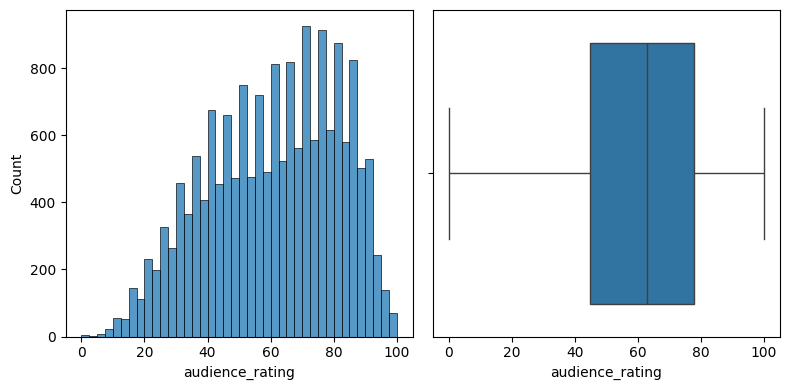

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# audience_rating
sns.histplot(ax = axis[0], data = movies, x = "audience_rating")
sns.boxplot(ax = axis[1], data = movies, x = "audience_rating")

plt.tight_layout()
plt.show()

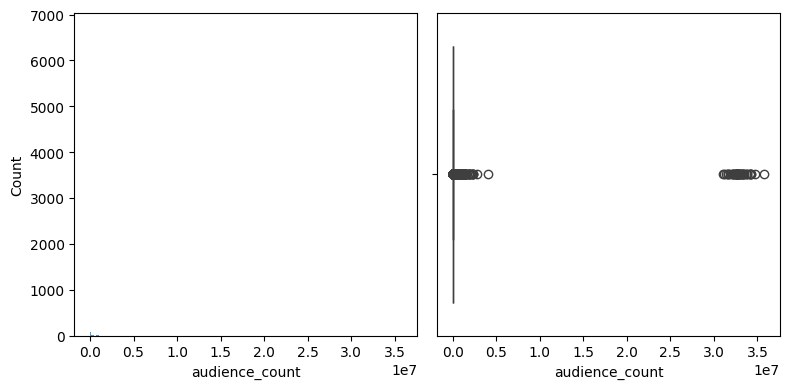

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# audience_count
sns.histplot(ax = axis[0], data = movies, x = "audience_count")
sns.boxplot(ax = axis[1], data = movies, x = "audience_count")

plt.tight_layout()
plt.show()

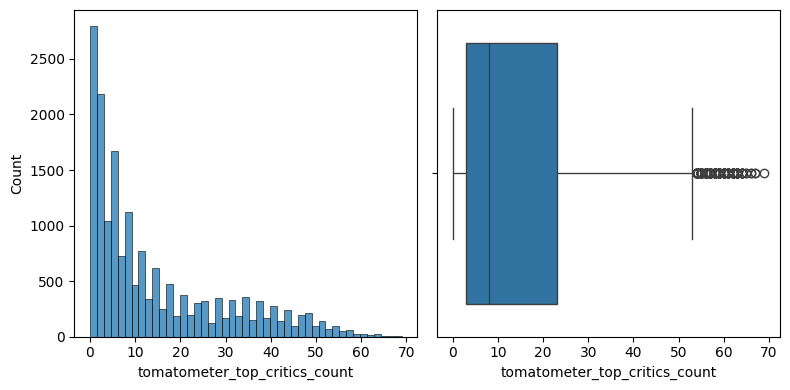

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# tomatometer_top_critics_count
sns.histplot(ax = axis[0], data = movies, x = "tomatometer_top_critics_count")
sns.boxplot(ax = axis[1], data = movies, x = "tomatometer_top_critics_count")

plt.tight_layout()
plt.show()

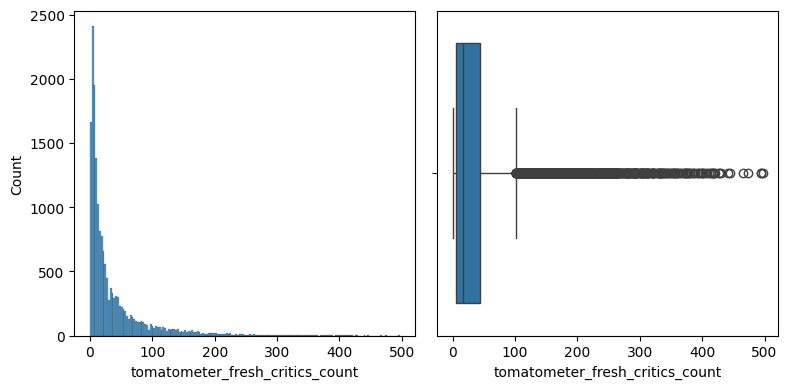

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# tomatometer_fresh_critics_count
sns.histplot(ax = axis[0], data = movies, x = "tomatometer_fresh_critics_count")
sns.boxplot(ax = axis[1], data = movies, x = "tomatometer_fresh_critics_count")

plt.tight_layout()
plt.show()

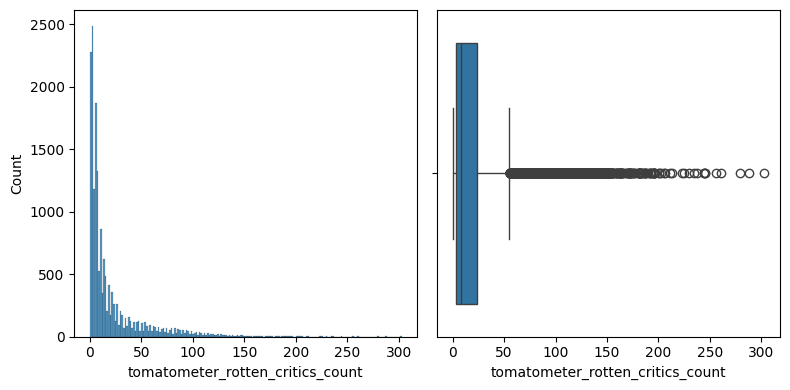

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# tomatometer_rotten_critics_count
sns.histplot(ax = axis[0], data = movies, x = "tomatometer_rotten_critics_count")
sns.boxplot(ax = axis[1], data = movies, x = "tomatometer_rotten_critics_count")

plt.tight_layout()
plt.show()

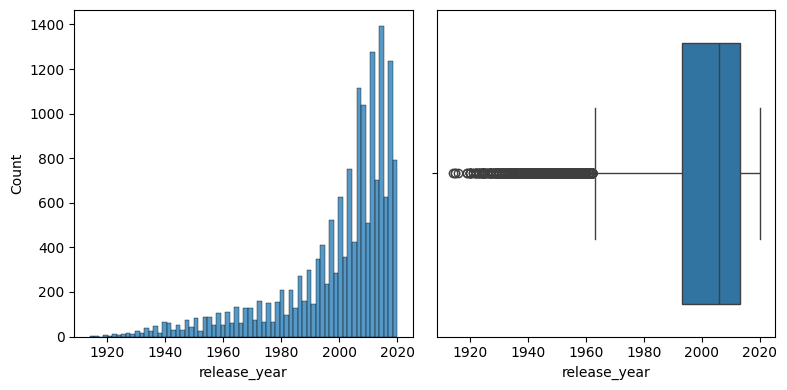

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# year
sns.histplot(ax = axis[0], data = movies[movies["release_year"] > 0], x = "release_year")
sns.boxplot(ax = axis[1], data = movies[movies["release_year"] > 0], x = "release_year")

plt.tight_layout()
plt.show()

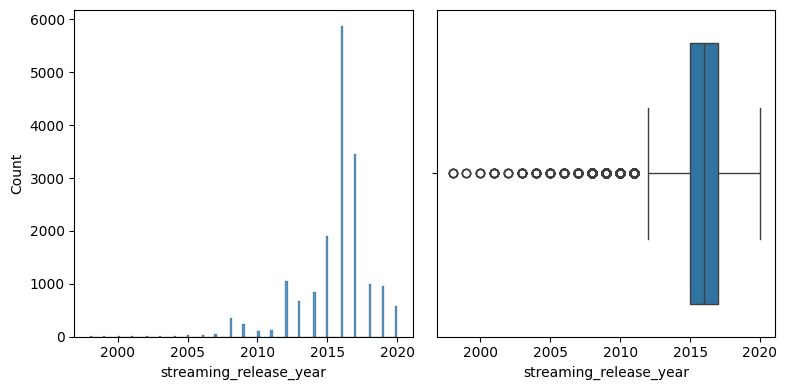

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4))

# year
sns.histplot(ax = axis[0], data = movies[movies["streaming_release_year"] > 0], x = "streaming_release_year")
sns.boxplot(ax = axis[1], data = movies[movies["streaming_release_year"] > 0], x = "streaming_release_year")

plt.tight_layout()
plt.show()

### 3.2 Variables Categóricas

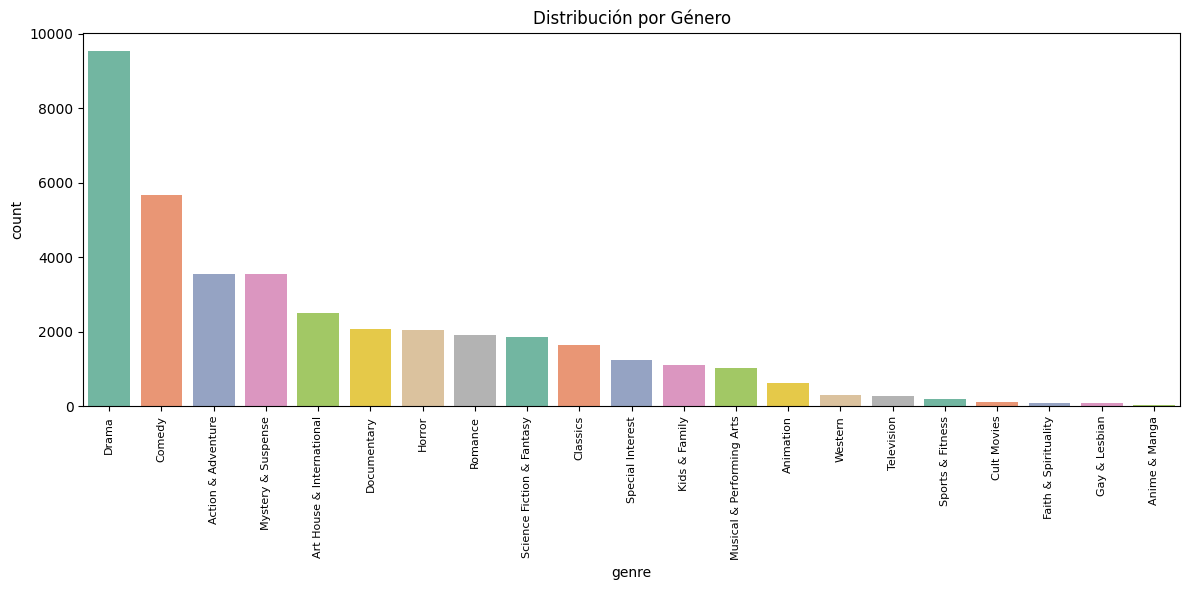

In [ ]:
#Genres
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_genre,
    x="genre",
    order=movie_genre["genre"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por Género")
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.tight_layout()
plt.show()

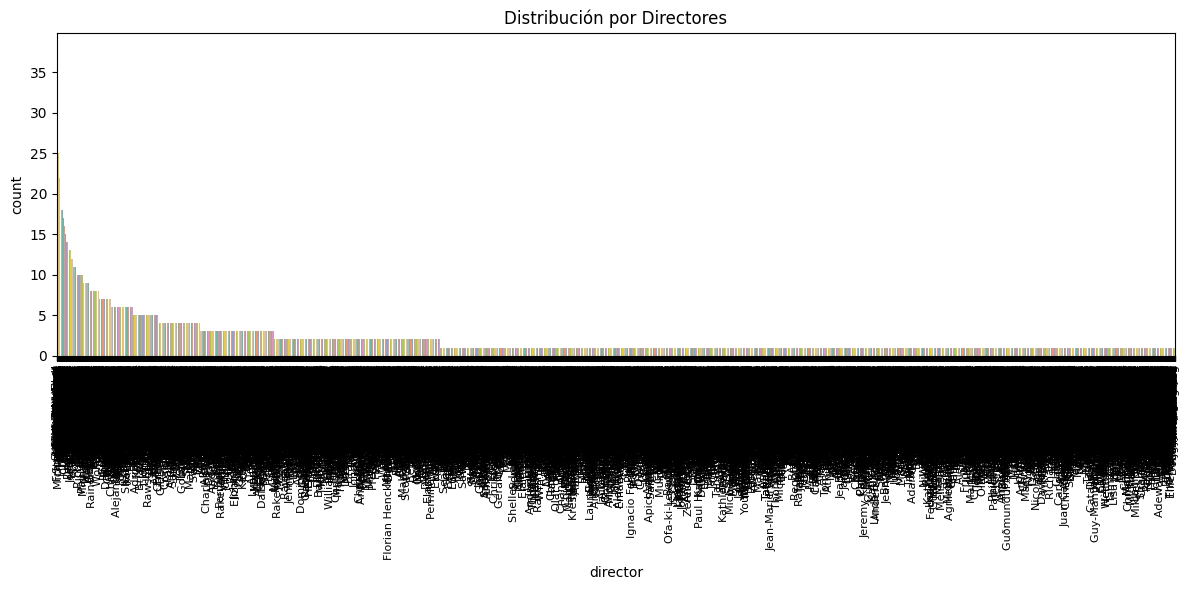

In [ ]:
#Directors
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_director,
    x="director",
    order=movie_director["director"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por Directores")
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.tight_layout()
plt.show()

Al tener tantos directores, nos enfocaremos en aquellos que hayan dirigido más de 10 películas.

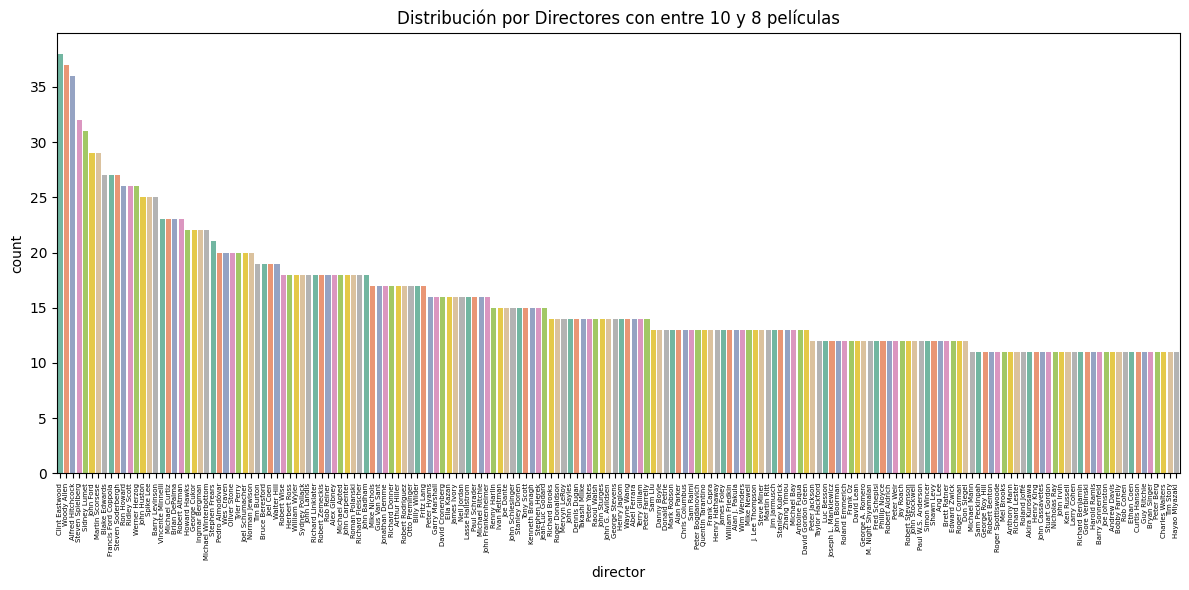

In [ ]:
# Contar películas por director
director_counts = movie_director['director'].value_counts()

# Filtrar solo directores con más de 10 películas
top_directors_over_10 = director_counts[director_counts > 10].index

# Filtrar el dataset
movie_director_over_10 = movie_director[movie_director['director'].isin(top_directors_over_10)]

# Gráfico
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_director_over_10,
    x="director",
    order=movie_director_over_10["director"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por Directores con entre 10 y 8 películas")
ax.tick_params(axis='x', rotation=90, labelsize=5)
plt.tight_layout()
plt.show()

### Autores

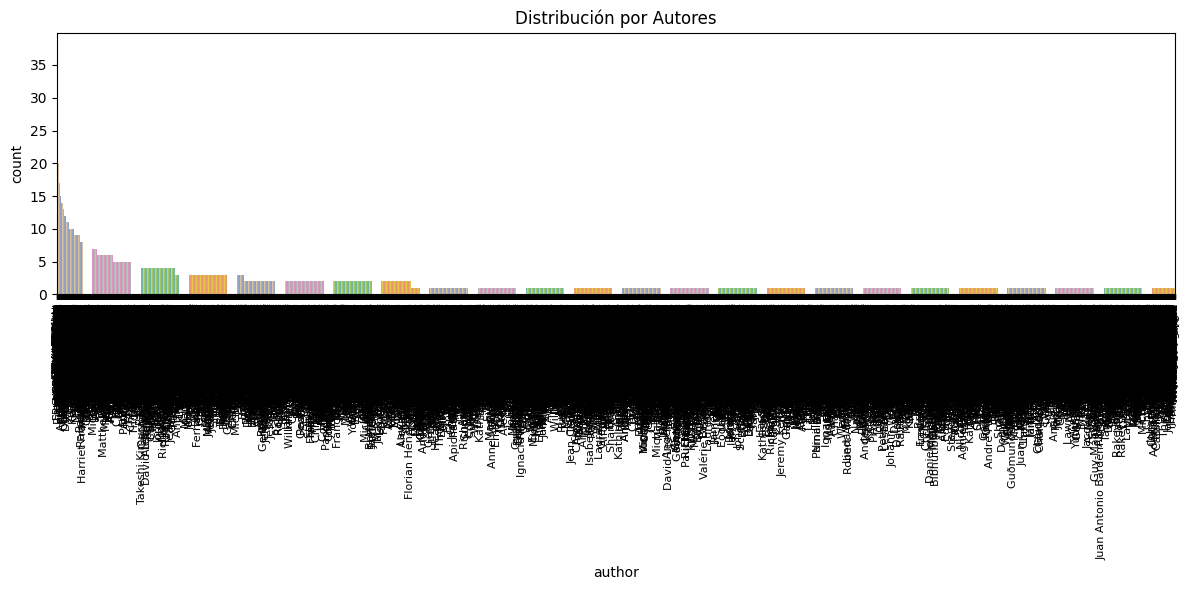

In [ ]:
#Autores
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_author,
    x="author",
    order=movie_author["author"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por Autores")
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.tight_layout()
plt.show()

Al tener tantos autores, nos enfocaremos en aquellos con más de 10 películas.

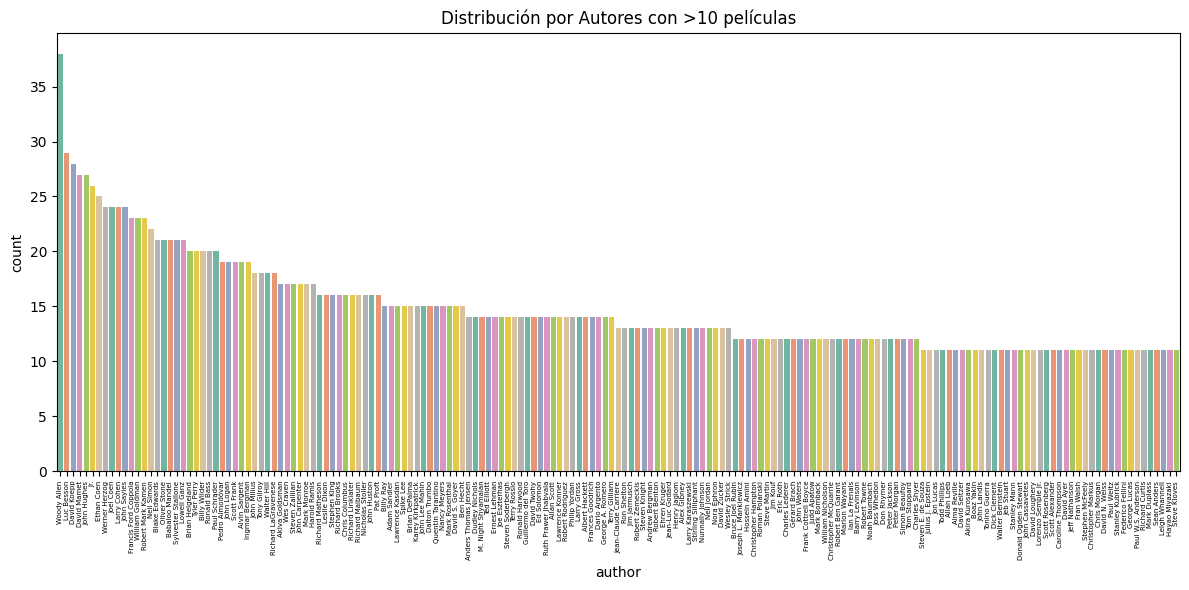

In [ ]:
author_counts = movie_author['author'].value_counts()

top_authors = author_counts[author_counts > 10].index

# Filtrar el dataset
movie_author_top = movie_author[movie_author['author'].isin(top_authors)]

# Gráfico
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_author_top,
    x="author",
    order=movie_author_top["author"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por Autores con >10 películas")
ax.tick_params(axis='x', rotation=90, labelsize=5)
plt.tight_layout()
plt.show()

Para el dataset de críticas, usaremos otro enfoque.

#### 3.2.1. Dividir el Dataset en categoricos y numericos

In [20]:
c_df_copy = critics.copy()
c_df_copy.dtypes.unique()

array([dtype('O'), dtype('bool')], dtype=object)

Todas las variables son categoricas.

#### 3.2.2 Análisis sober variables categóricas

In [ ]:
print(c_df_copy['rotten_tomatoes_link'].value_counts().head(10))
print(f"Total de productos únicos: {c_df_copy['rotten_tomatoes_link'].nunique()}")
print("------------------------------------------------------")
print(c_df_copy['publisher_name'].value_counts().head(10))
print(f"Total de editoriales únicos: {c_df_copy['publisher_name'].nunique()}")

rotten_tomatoes_link
m/joker_2019                         574
m/once_upon_a_time_in_hollywood      554
m/us_2019                            535
m/avengers_endgame                   528
m/captain_marvel                     523
m/a_star_is_born_2018                517
m/black_panther_2018                 512
m/star_wars_the_rise_of_skywalker    496
m/solo_a_star_wars_story             474
m/star_wars_the_last_jedi            473
Name: count, dtype: int64
Total de productos únicos: 17697
------------------------------------------------------
publisher_name
New York Times        11816
Variety               10404
Time Out               9035
Los Angeles Times      9017
Slant Magazine         8073
Washington Post        8058
Hollywood Reporter     8045
eFilmCritic.com        7984
Village Voice          7345
Chicago Sun-Times      7202
Name: count, dtype: int64
Total de editoriales únicos: 2229


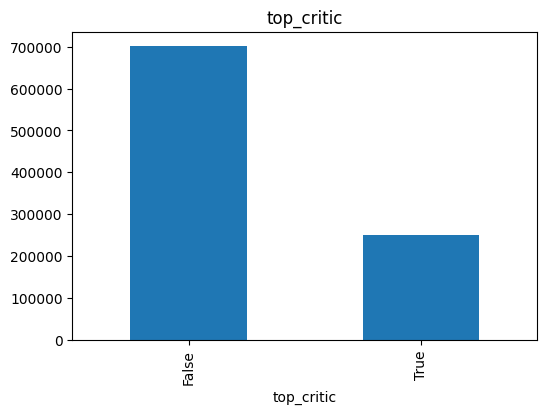

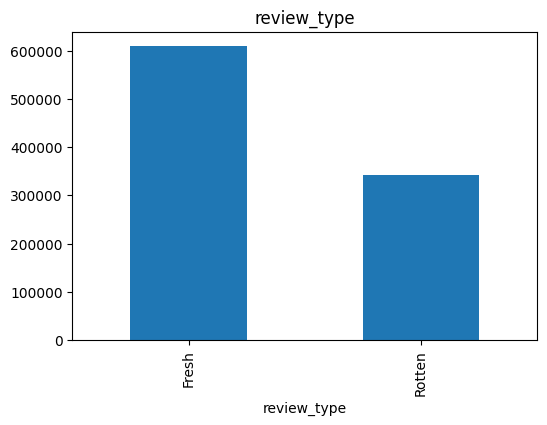

In [ ]:
categorical_cols = [ 'top_critic', 'review_type']


for col in categorical_cols:
    c_df_copy[col].value_counts().plot(kind='bar', figsize=(6,4), title=col)
    plt.show()

- La mayoría de críticos no son destacados en una proporción casi dos veces más que los que sí lo son.
- Las reseñas positivas son casi el doble de las negativas.

Top 10 peliculas graficados: 10
Top 10 editoriales graficados: 10


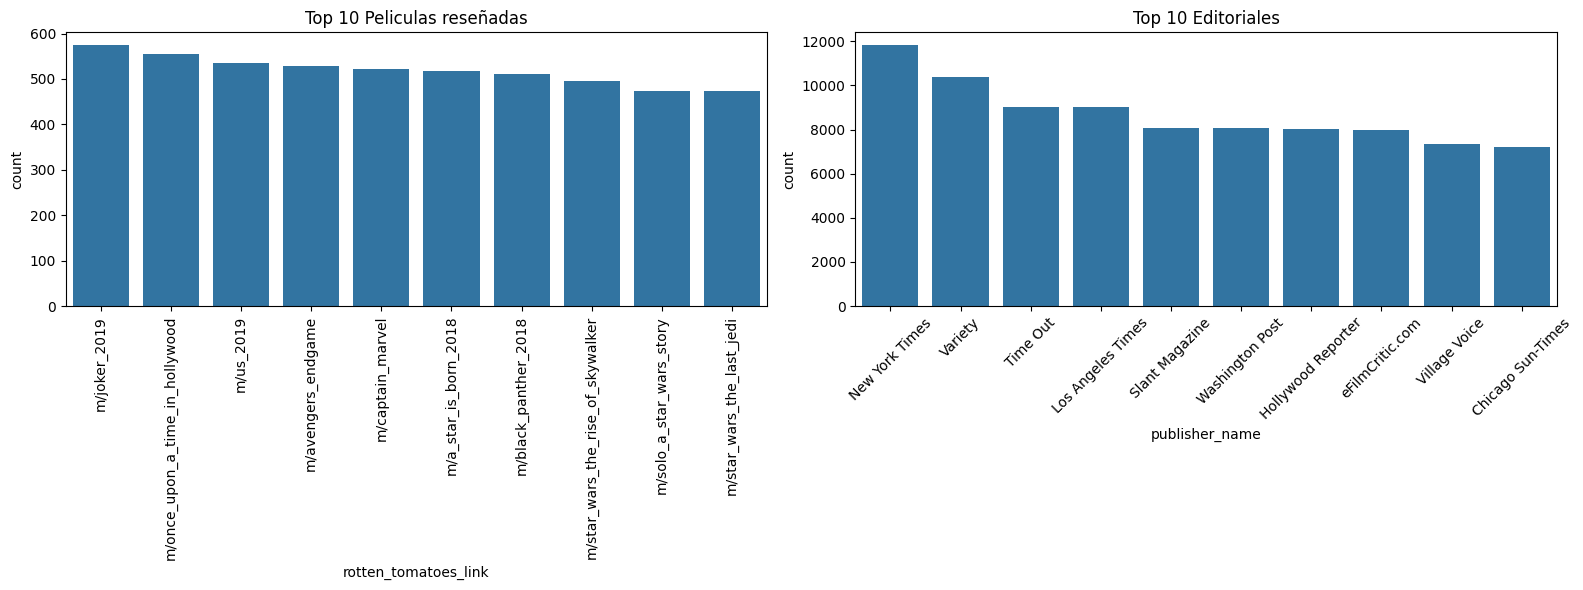

In [ ]:
top_n_peliculas = 10
top_n_editorial = 10

fig, axis = plt.subplots(1, 2, figsize=(16, 6))

# PRODUCTOS
top_products = c_df_copy['rotten_tomatoes_link'].value_counts().head(top_n_peliculas).index
sns.countplot(ax=axis[0], data=c_df_copy, x='rotten_tomatoes_link', order=top_products)
axis[0].set_title("Top 10 Peliculas reseñadas")
axis[0].tick_params(axis='x', rotation=90)
print("Top 10 peliculas graficados:", len(top_products))

# USUARIOS
top_users = c_df_copy['publisher_name'].value_counts().head(top_n_editorial).index
sns.countplot(ax=axis[1], data=c_df_copy, x='publisher_name', order=top_users)
axis[1].set_title("Top 10 Editoriales")
axis[1].tick_params(axis='x', rotation=45)
print("Top 10 editoriales graficados:", len(top_users))

plt.tight_layout()
plt.show()

- El top de peliculas reseñadas esta rodeando las 500 reseñas.
- La editorial con mas reseñas de películas es New York Times con casi 12000, avanzando de manera descendente hasta Chicado Sun-Times con casi 8000.

## 4. Análisis Multivariante

### 4.1 Análisis Numérico - Numérico

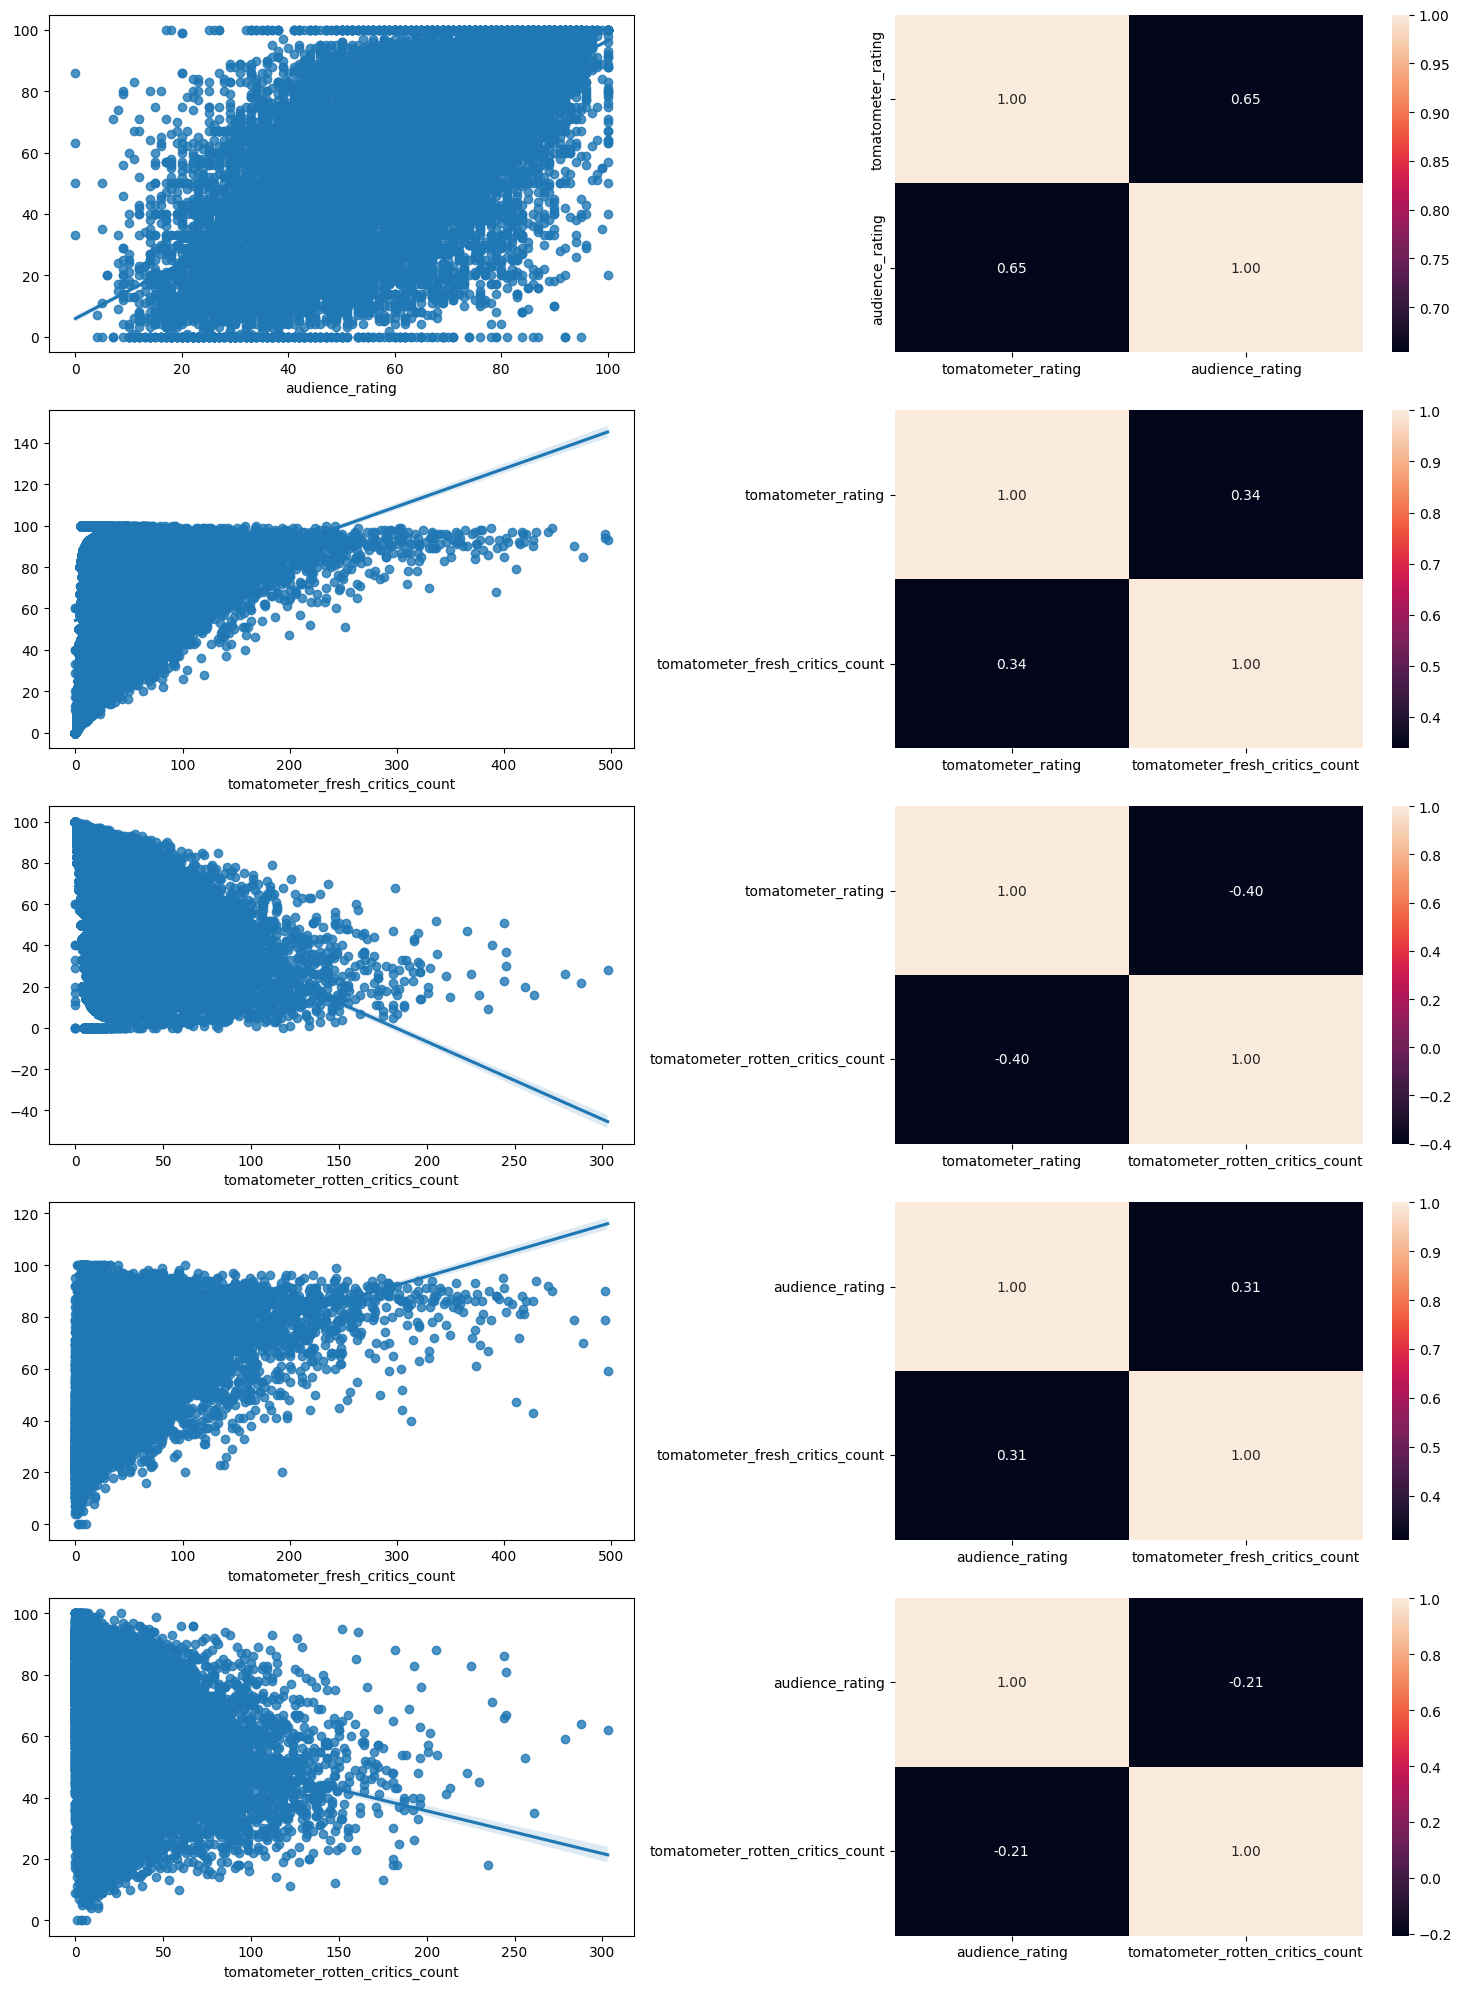

In [ ]:
fig, axis = plt.subplots(5, 2, figsize = (15, 20))

# Crear un diagrama de dispersión múltiple

sns.regplot(ax = axis[0, 0], data = movies, x = "audience_rating", y = "tomatometer_rating").set(ylabel=None)
sns.heatmap(movies[["tomatometer_rating", "audience_rating"]].corr(), annot = True, fmt = ".2f", ax = axis[0, 1])

sns.regplot(ax = axis[1, 0], data = movies, x = "tomatometer_fresh_critics_count", y = "tomatometer_rating").set(ylabel=None)
sns.heatmap(movies[["tomatometer_rating", "tomatometer_fresh_critics_count"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = movies, x = "tomatometer_rotten_critics_count", y = "tomatometer_rating").set(ylabel=None)
sns.heatmap(movies[["tomatometer_rating", "tomatometer_rotten_critics_count"]].corr(), annot = True, fmt = ".2f", ax = axis[2, 1])

sns.regplot(ax = axis[3, 0], data = movies, x = "tomatometer_fresh_critics_count", y = "audience_rating").set(ylabel=None)
sns.heatmap(movies[["audience_rating", "tomatometer_fresh_critics_count"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

sns.regplot(ax = axis[4, 0], data = movies, x = "tomatometer_rotten_critics_count", y = "audience_rating").set(ylabel=None)
sns.heatmap(movies[["audience_rating", "tomatometer_rotten_critics_count"]].corr(), annot = True, fmt = ".2f", ax = axis[4, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

### 4.2 Análisis Categórico - Categórico

In [ ]:
def cat_cat(df, cat1, cat2, top_n_cat1=None, top_n_cat2=None):
    
    if top_n_cat1:
        top_values1 = df[cat1].value_counts().nlargest(top_n_cat1).index
        df = df[df[cat1].isin(top_values1)]
    if top_n_cat2:
        top_values2 = df[cat2].value_counts().nlargest(top_n_cat2).index
        df = df[df[cat2].isin(top_values2)]
    
    ct = pd.crosstab(df[cat1], df[cat2])
    
    ct_prop = ct.div(ct.sum(axis=1).replace(0,1), axis=0)
    
    ct_prop.plot(kind='bar', stacked=True, figsize=(12,6))
    plt.xlabel(cat1)
    plt.ylabel('Proporción')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=cat2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
movies_exploded_dir = movies.explode('directors')

movies_exploded_dir = movies_exploded_dir[movies_exploded_dir['directors'] != '']
movies_exploded_dir = movies_exploded_dir.dropna(subset=['directors'])

top10_directors = (
    movies_exploded_dir['directors']
    .value_counts()
    .head(10)
    .index
)
movies_top_directors = movies_exploded_dir[movies_exploded_dir['directors'].isin(top10_directors)]

In [ ]:
movies_exploded_aut = movies.explode('authors')

movies_exploded_aut = movies_exploded_aut[movies_exploded_aut['authors'] != '']
movies_exploded_aut = movies_exploded_aut.dropna(subset=['authors'])

top10_authors = (
    movies_exploded_aut['authors']
    .value_counts()
    .head(10)
    .index
)
movies_top_authors = movies_exploded_aut[movies_exploded_aut['authors'].isin(top10_authors)]

In [ ]:
movies_exploded_act = movies.explode('actors')

movies_exploded_act = movies_exploded_act[movies_exploded_act['actors'] != '']
movies_exploded_act = movies_exploded_act.dropna(subset=['actors'])

top10_actors = (
    movies_exploded_act['actors']
    .value_counts()
    .head(10)
    .index
)
movies_top_actors = movies_exploded_act[movies_exploded_act['actors'].isin(top10_actors)]

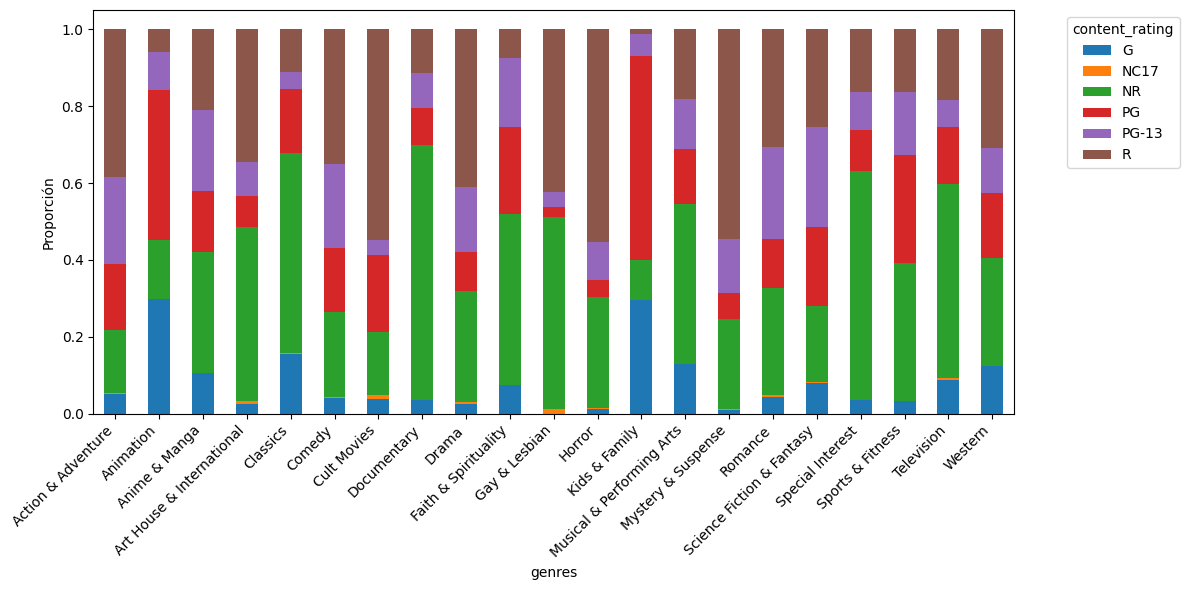

In [ ]:
movies_exploded_genres = movies.explode('genres')

cat_cat(
    df=movies_exploded_genres,
    cat1='genres',        
    cat2='content_rating',
    top_n_cat1=None,      
    top_n_cat2=None       
)


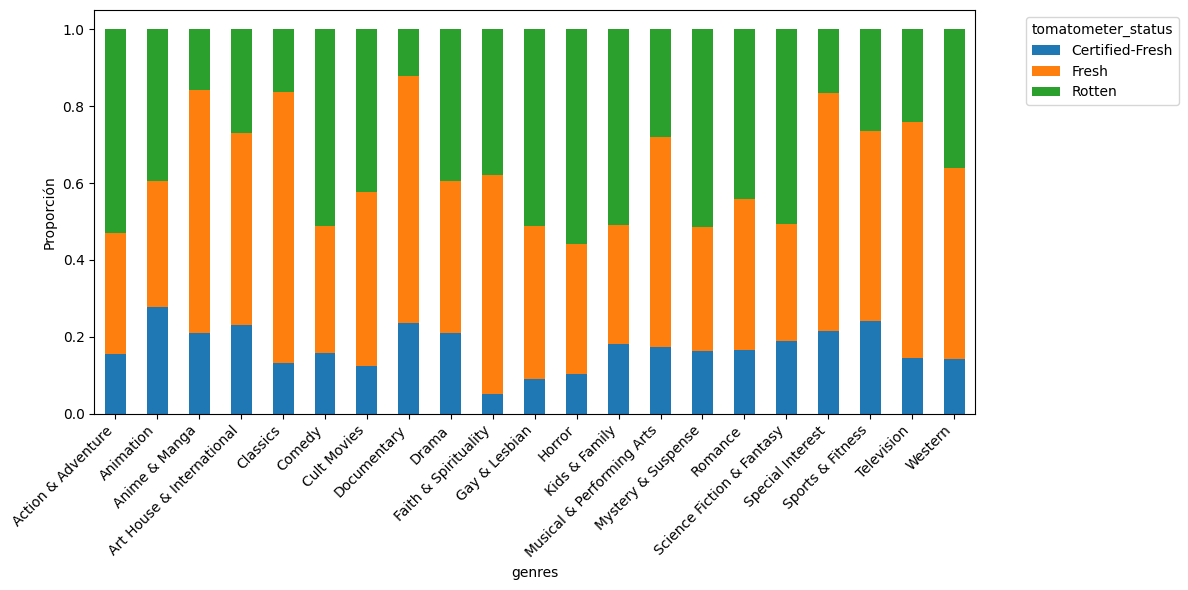

In [ ]:
cat_cat(
    df=movies_exploded_genres,
    cat1='genres',        
    cat2='tomatometer_status',
    top_n_cat1=None,      
    top_n_cat2=None       
)

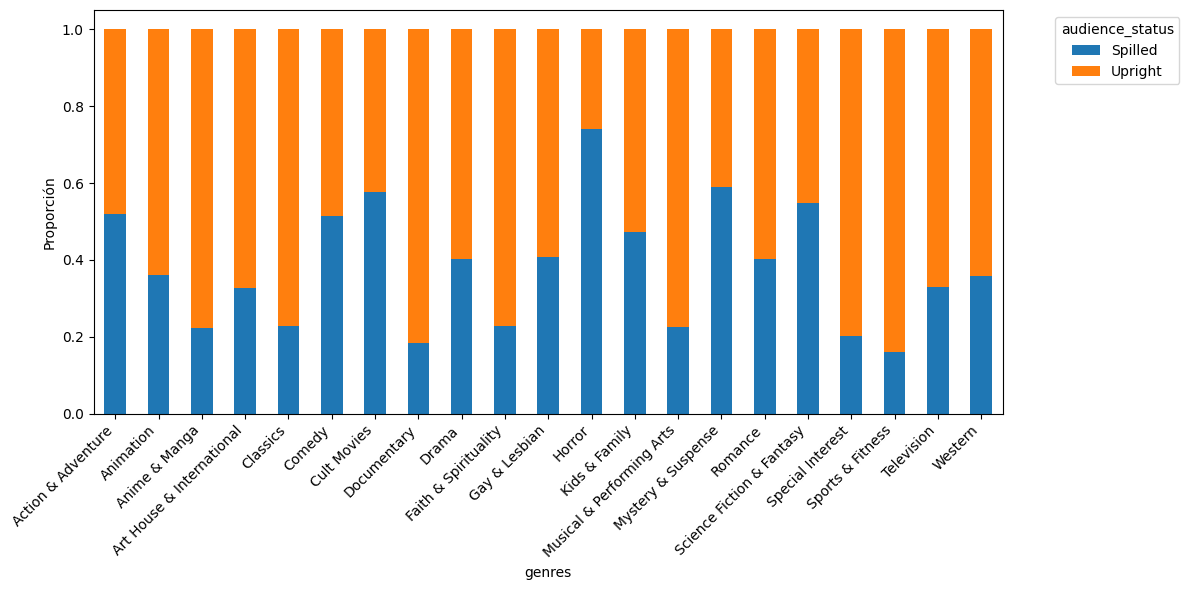

In [ ]:
cat_cat(
    df=movies_exploded_genres,
    cat1='genres',        
    cat2='audience_status',
    top_n_cat1=None,      
    top_n_cat2=None       
)

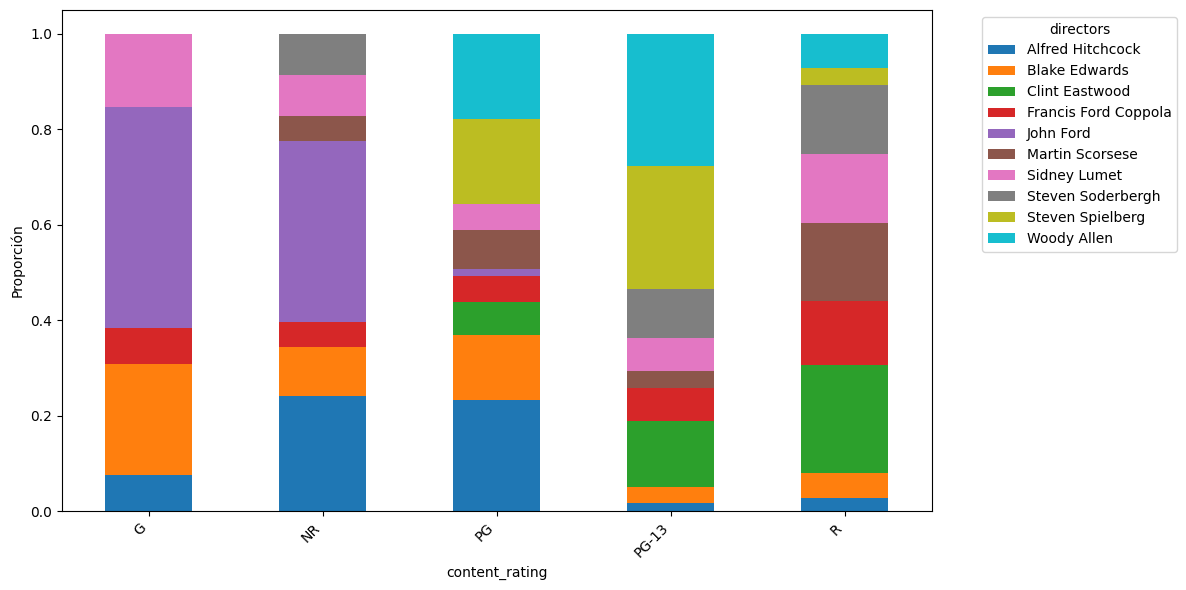

In [ ]:
cat_cat(
    df=movies_top_directors,
    cat1='content_rating',        
    cat2='directors',
    top_n_cat1=None,      
    top_n_cat2=None       
)


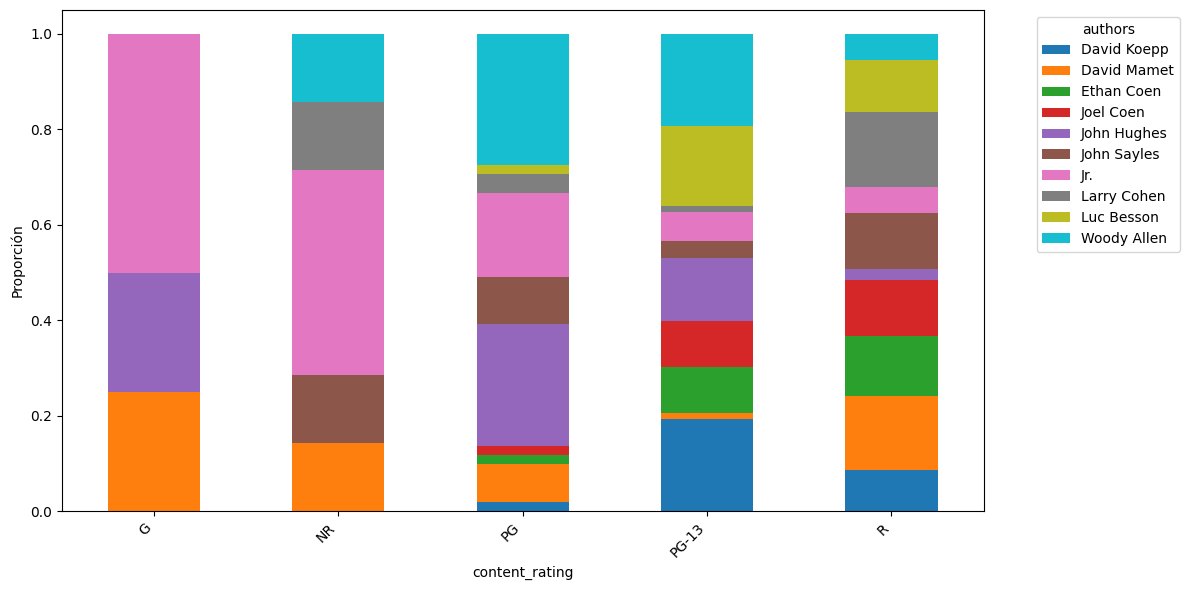

In [ ]:
cat_cat(
    df=movies_top_authors,
    cat1='content_rating',        
    cat2='authors',
    top_n_cat1=None,      
    top_n_cat2=None       
)

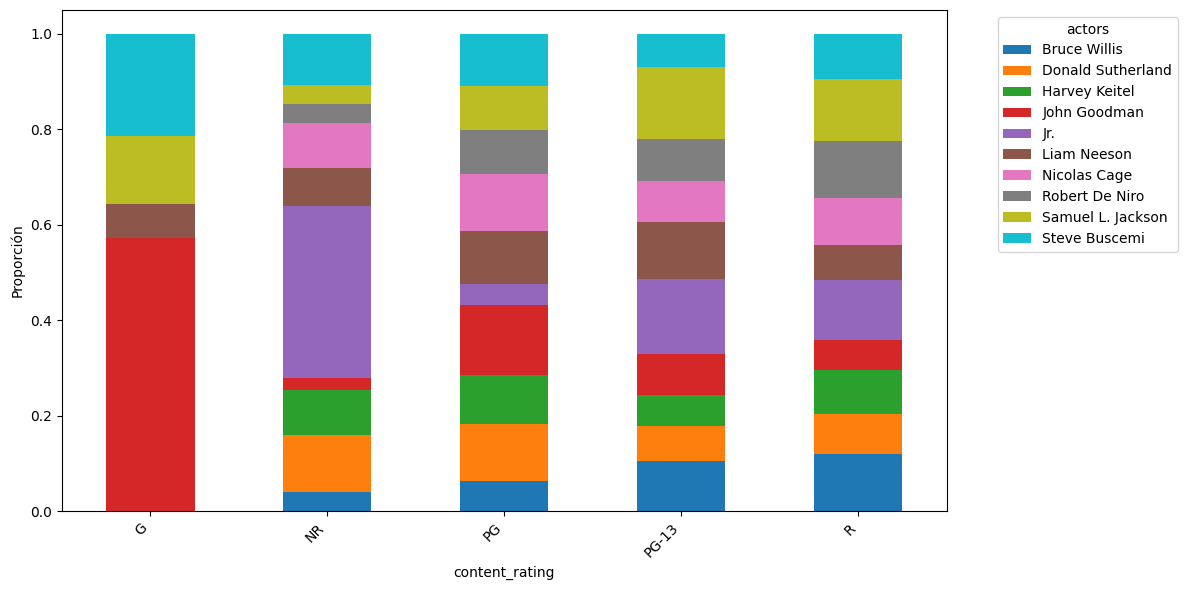

In [ ]:
cat_cat(
    df=movies_top_actors,
    cat1='content_rating',        
    cat2='actors',
    top_n_cat1=None,      
    top_n_cat2=None       
)

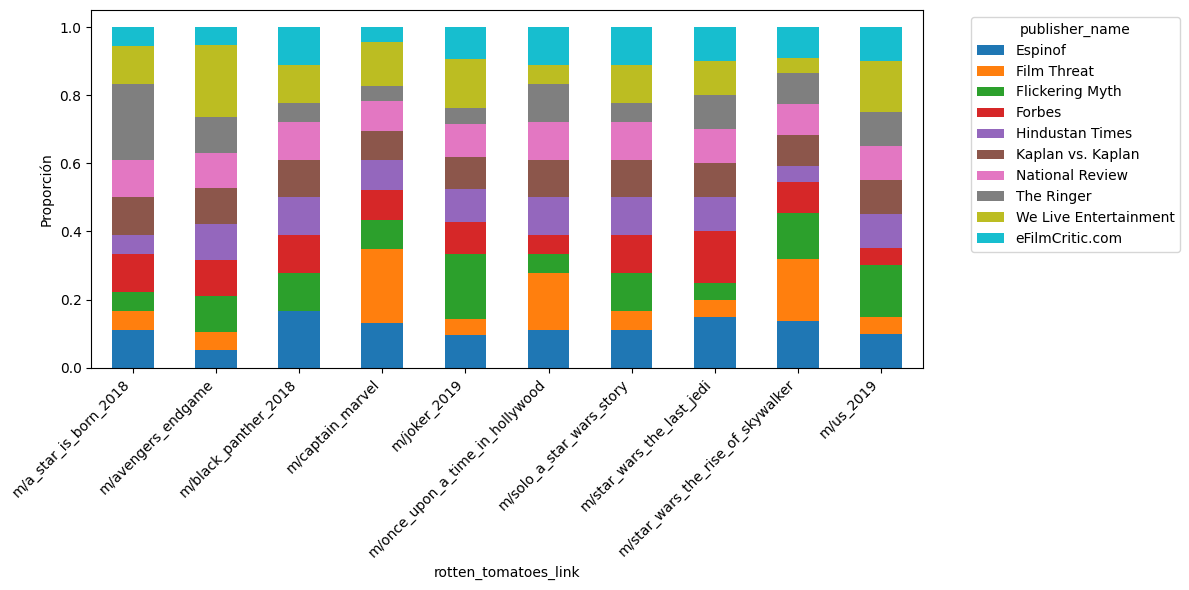

In [ ]:
cat_cat(c_df_copy, 'rotten_tomatoes_link', 'publisher_name', top_n_cat1=top_n_peliculas, top_n_cat2=top_n_editorial)

Parece que eFilmCritic.com es quien más reseñas hace a las peliculas con más reseñas del top.

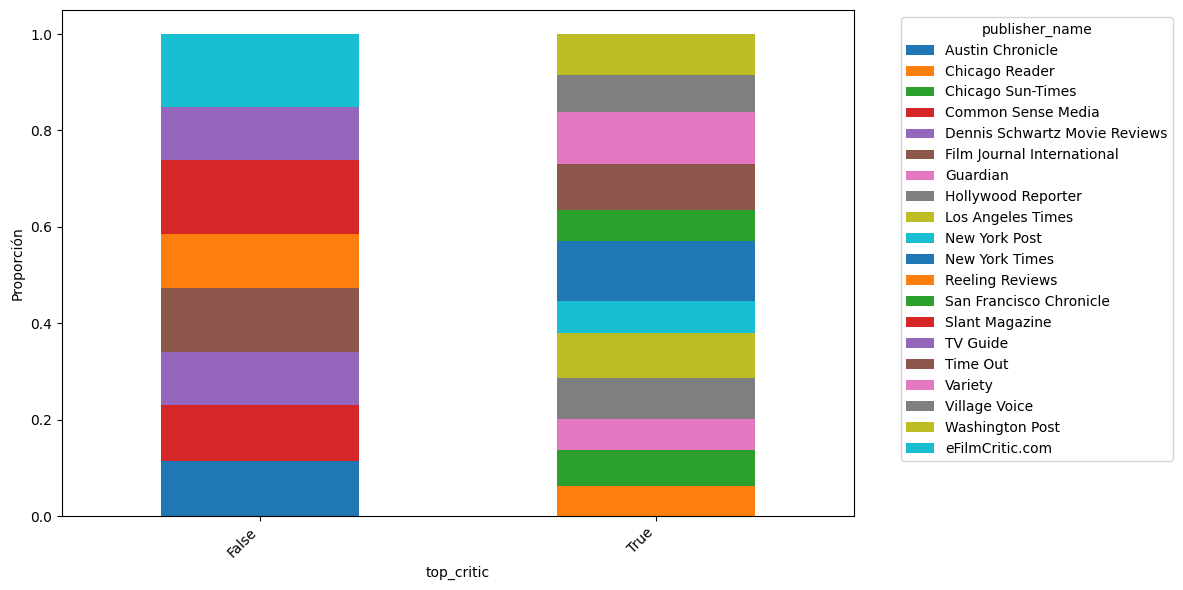

In [ ]:
cat_cat(c_df_copy, 'top_critic', 'publisher_name', top_n_cat2=20)

Se ve que la mayoría de las editoriales con mas reseñas tienen críticos cuya opinión es validada, es importante teniendo en cuenta que hay más con la categoría false que con true.

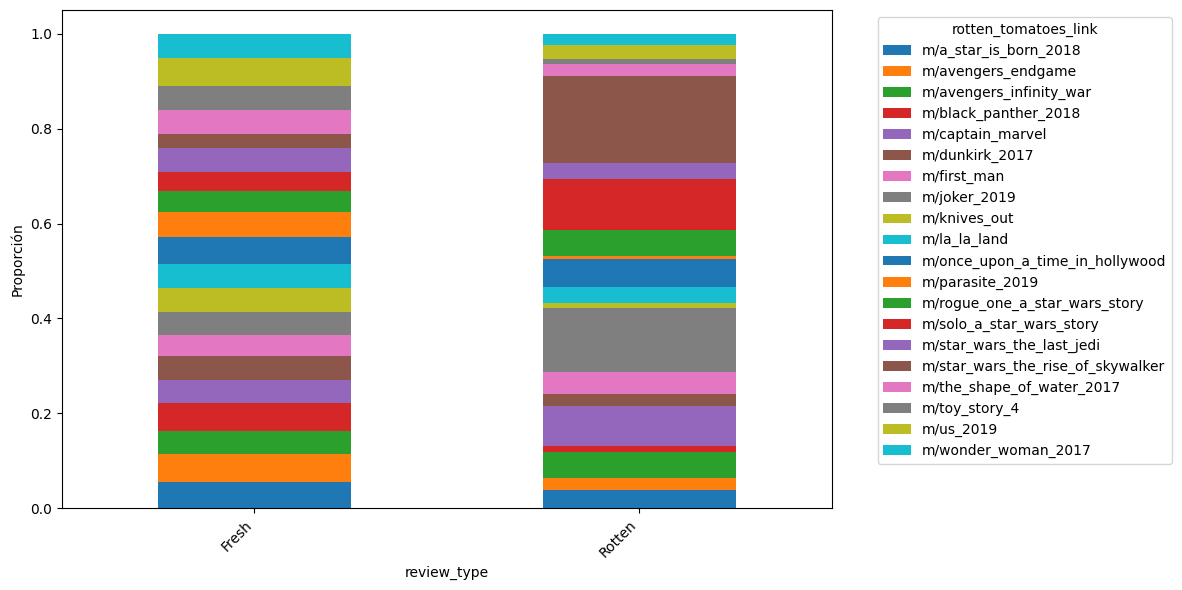

In [ ]:
cat_cat(c_df_copy, 'review_type', 'rotten_tomatoes_link', top_n_cat2=20)

Las buenas reseñas estan distribuidas mas equitativamente entre las películas mientras que las malas se acumulan, esto sugiere que se le da importancia a que hay películas con más reseñas malas que buenas.

### 4.3 Análisis Numérico - Categórico

### 4.3.1 Matriz de Correlación Múltiple

Para continuar con el análisis de las variables categóricas y poder hacer un gráfico de correlaciones, debemos transformar estas variables en variables numéricas.

In [ ]:
movies_n = movies.copy()

In [ ]:
movies_n["content_rating_n"] = pd.factorize(movies_n["content_rating"])[0]
movies_n["production_company_n"] = pd.factorize(movies_n["production_company"])[0]
movies_n["tomatometer_status_n"] = pd.factorize(movies_n["tomatometer_status"])[0]
movies_n["audience_status_n"] = pd.factorize(movies_n["audience_status"])[0]

In [ ]:
cols = [
    "content_rating_n",
    "release_year",
    "streaming_release_year",
    "runtime",
    "production_company_n",
    "tomatometer_status_n",
    "tomatometer_rating",
    "tomatometer_count",
    "audience_status_n",
    "audience_rating",
    "audience_count",
    "tomatometer_top_critics_count",
    "tomatometer_fresh_critics_count",
    "tomatometer_rotten_critics_count"
]

movies_corr = movies_n[cols]

movies_corr = movies_corr.fillna(0)


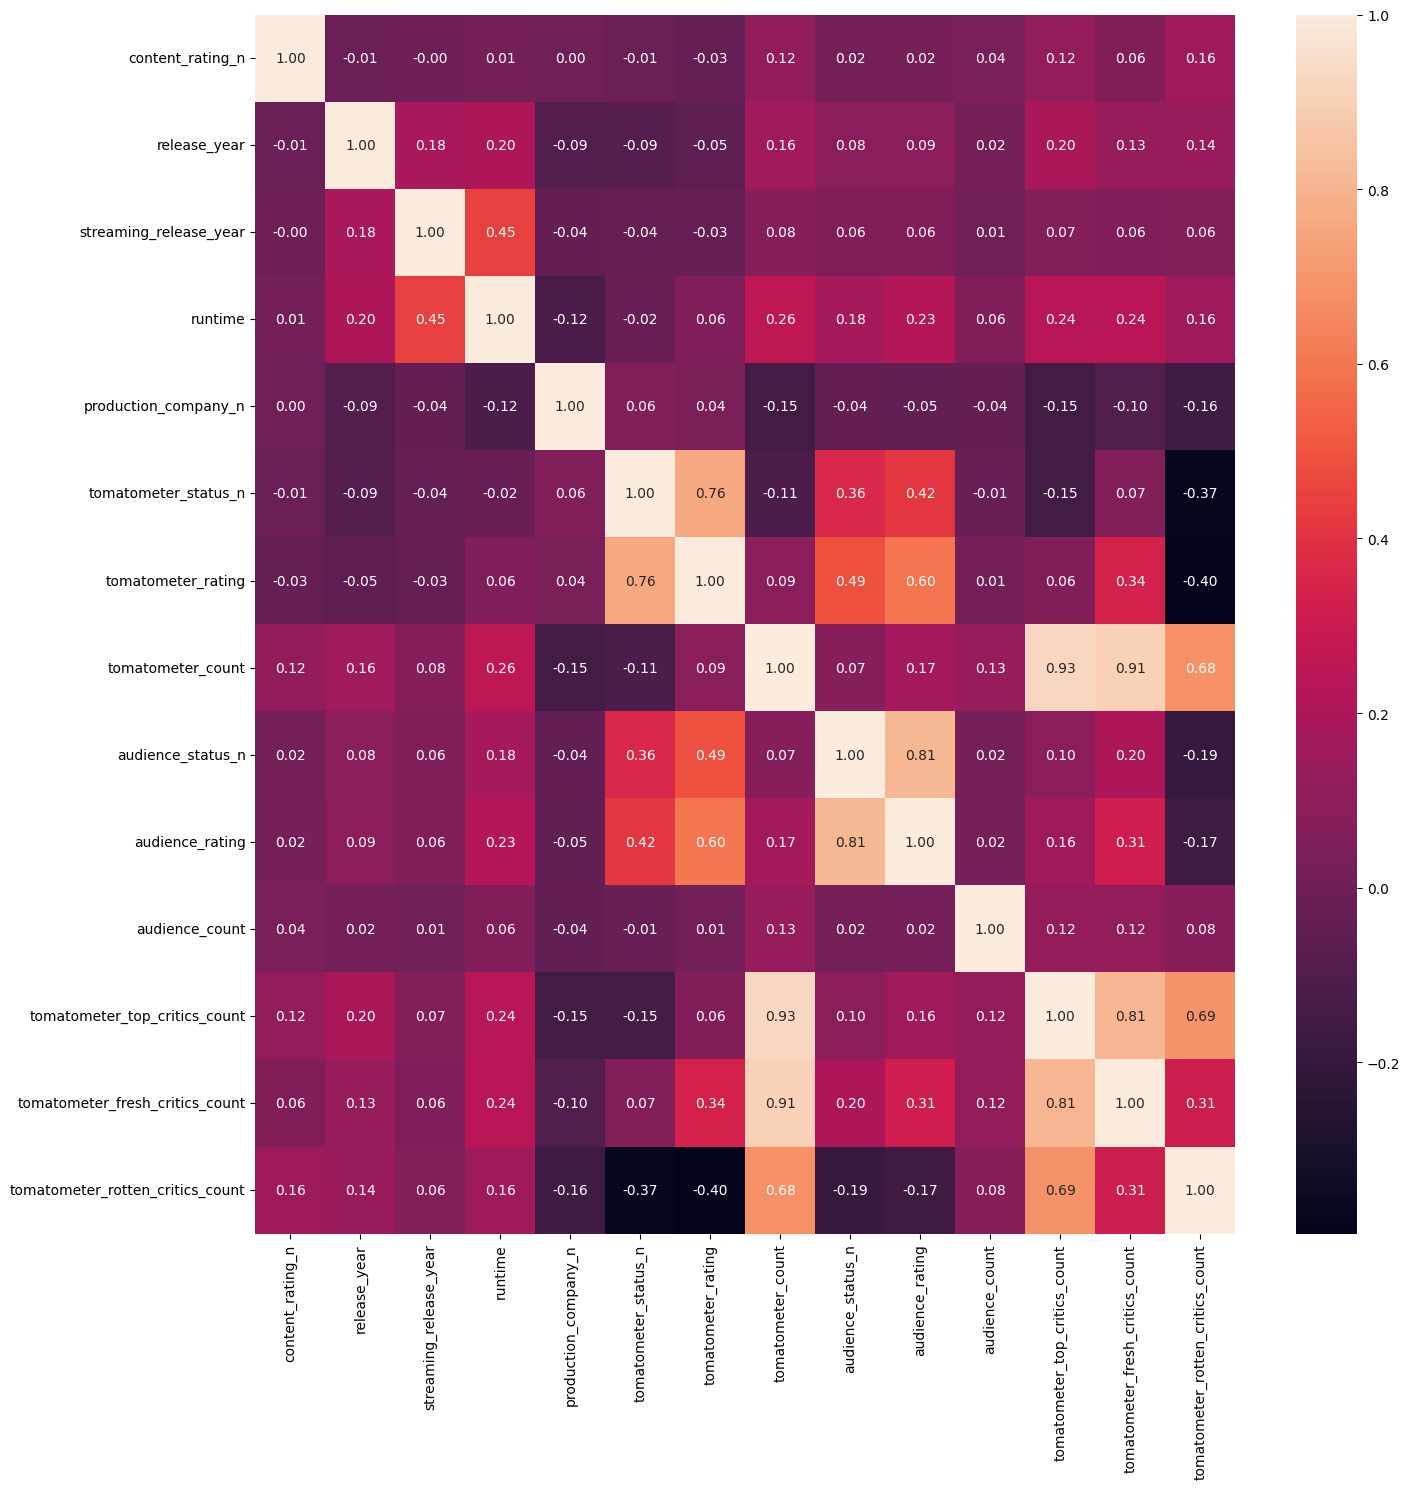

In [ ]:
corr_matrix = movies_corr.corr()

fig, axis = plt.subplots(figsize = (15, 15))

sns.heatmap(corr_matrix, annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

## 5. Ingeniería de características

### 5.1. Preparar los datos

Como primera etapa vamos a mapear las reseñas de frescas o podridas como boolean

In [21]:
c_df_copy['review_label'] = c_df_copy['review_type'].map({'Fresh': 1, 'Rotten': 0})

print(c_df_copy[['review_type', 'review_label']].head())
c_df_copy.drop(columns=['review_type'], inplace=True)

  review_type  review_label
0       Fresh             1
1       Fresh             1
2       Fresh             1
3       Fresh             1
4      Rotten             0


In [22]:
c_df_copy.head()

,rotten_tomatoes_link,top_critic,publisher_name,review_content,review_label
0,m/0814255,False,Urban Cinefile,A fantasy adventure that fuses Greek mythology...,1
1,m/0814255,False,Urban Cinefile,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,m/0814255,False,FILMINK (Australia),With a top-notch cast and dazzling special eff...,1
3,m/0814255,False,Sunday Mail (Australia),Whether audiences will get behind The Lightnin...,1
4,m/0814255,True,Hollywood Reporter,What's really lacking in The Lightning Thief i...,0


In [23]:
c_df_copy['top_critic_num'] = c_df_copy['top_critic'].astype(int)
c_df_copy.drop(columns=['top_critic'], inplace=True)

In [24]:
c_df_copy['review_len'] = c_df_copy['review_content'].str.len()

# cantidad de palabras
c_df_copy['review_word_count'] = c_df_copy['review_content'].str.split().apply(len)

In [25]:
c_df_copy.head()

,rotten_tomatoes_link,publisher_name,review_content,review_label,top_critic_num,review_len,review_word_count
0,m/0814255,Urban Cinefile,A fantasy adventure that fuses Greek mythology...,1,0,176,29
1,m/0814255,Urban Cinefile,"Uma Thurman as Medusa, the gorgon with a coiff...",1,0,153,25
2,m/0814255,FILMINK (Australia),With a top-notch cast and dazzling special eff...,1,0,121,20
3,m/0814255,Sunday Mail (Australia),Whether audiences will get behind The Lightnin...,1,0,213,37
4,m/0814255,Hollywood Reporter,What's really lacking in The Lightning Thief i...,0,1,147,26


### 5.2. Análisis de outliers

Sólo se tendrán en cuenta que las reseñas con una longitud mínima.

In [26]:
c_df_copy = c_df_copy[(c_df_copy['review_len'] >= 10) & (c_df_copy['review_len'] <= 5000)]

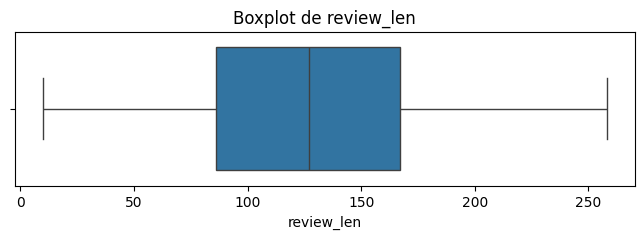

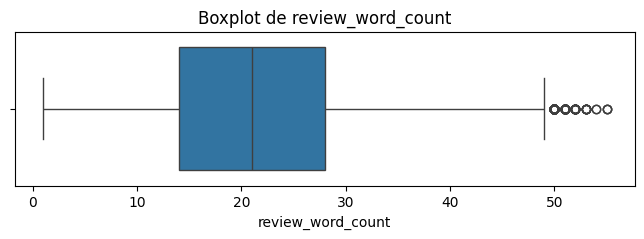

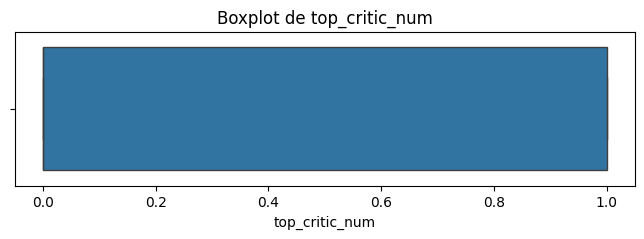

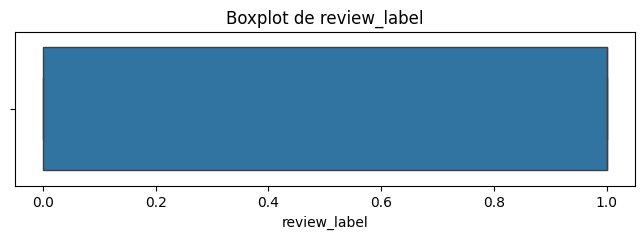

In [27]:
num_cols = ['review_len', 'review_word_count', 'top_critic_num', 'review_label']

for col in num_cols:
    plt.figure(figsize=(8,2))
    sns.boxplot(x=c_df_copy[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

### 5.3. Dividir el train/test de marcos de datos

In [28]:
X = c_df_copy['review_content']  
y = c_df_copy['review_label']    

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Transformar el texto en matriz

In [29]:
vec_model = CountVectorizer(stop_words = "english", max_features=5000)
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec = vec_model.transform(X_test)

## 7. Construir el Modelo usando Naive Bayes

In [30]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred_nb = nb_model.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.771371048287898


## 8. Optimización

In [31]:
def evaluar_modelo(model, X_train_vec, X_test_vec, y_train, y_test, nombre="Modelo"):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"{nombre} Accuracy: {acc:.5f}")
    return model, y_pred

In [32]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}

In [33]:
# Naive Bayes simple
vec_model = CountVectorizer(stop_words="english")
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec  = vec_model.transform(X_test)

nb_model = MultinomialNB()
nb_model, y_pred_nb = evaluar_modelo(nb_model, X_train_vec, X_test_vec, y_train, y_test, "Naive Bayes")

Naive Bayes Accuracy: 0.79712


In [34]:
# 5. Naive Bayes optimizado con Pipeline + RandomizedSearchCV
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}

grid = RandomizedSearchCV(pipeline, hyperparams, scoring="accuracy", n_iter=20, random_state=42)
grid.fit(X_train, y_train)

best_nb_model = grid.best_estimator_
y_pred_best_nb = best_nb_model.predict(X_test)

print("Naive Bayes Optimizado Accuracy:", accuracy_score(y_test, y_pred_best_nb))
print("Mejores parámetros:", grid.best_params_)

Naive Bayes Optimizado Accuracy: 0.8029742317356519
Mejores parámetros: {'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': None, 'nb__alpha': np.float64(0.7)}


In [35]:
#Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model, y_pred_log = evaluar_modelo(log_model, X_train_vec, X_test_vec, y_train, y_test, "Logistic Regression")

Logistic Regression Accuracy: 0.80569


In [36]:
acc_nb = accuracy_score(y_test, y_pred_best_nb)
acc_log = accuracy_score(y_test, y_pred_log)

if acc_log > acc_nb:
    modelo_final = log_model
    nombre_final = "Logistic Regression"
else:
    modelo_final = best_nb_model
    nombre_final = "Naive Bayes Optimizado"

print(f"Mejor modelo: {nombre_final} ({max(acc_nb, acc_log):.5f})")

Mejor modelo: Logistic Regression (0.80569)


In [37]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(stop_words="english")),
    ("classifier", modelo_final)   
])

pipeline.fit(X_train, y_train)

# Guardar el pipeline completo
with open("../models/rotten_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("Pipeline con modelo final guardado correctamente.")

Pipeline con modelo final guardado correctamente.


## 9. Combinar Datasets

Para el sistema de recomendación, necesitaremos trabajar con un único modelo, por lo cual agregaremos al dataset *movies* una columna adicional que contenga el valor promedio del puntaje obtenido al hacer el análisis de sentimientos.

In [38]:
critics["review_content"] = critics["review_content"].fillna("")

critics["sentiment_prob"] = pipeline.predict_proba(critics["review_content"])[:, 1]

In [62]:
# Aqui se argupan por el id y se saca la media
sentiment_scores = critics.groupby("rotten_tomatoes_link")["sentiment_prob"].mean().reset_index()
sentiment_scores.rename(columns={"sentiment_prob": "avg_sentiment_score"}, inplace=True)

# Unir al dataset de películas
movies = movies.merge(sentiment_scores, on="rotten_tomatoes_link", how="left")

In [63]:
movies.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,runtime,...,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,release_year,streaming_release_year,avg_sentiment_score
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"[Action & Adventure, Comedy, Drama, Science Fi...",[Chris Columbus],"[Craig Titley, Chris Columbus, Rick Riordan]","[Logan Lerman, Brandon T. Jackson, Alexandra D...",119.0,...,149.0,Spilled,53.0,254421.0,43,73,76,2010,2015,0.552701
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,[Comedy],[Nicole Holofcener],[Nicole Holofcener],"[Catherine Keener, Amanda Peet, Oliver Platt, ...",90.0,...,142.0,Upright,64.0,11574.0,44,123,19,2010,2012,0.811820
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"[Comedy, Romance]",[Blake Edwards],[Blake Edwards],"[Dudley Moore, Bo Derek, Julie Andrews, Robert...",122.0,...,24.0,Spilled,53.0,14684.0,2,16,8,1979,2014,0.597555
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"[Classics, Drama]",[Sidney Lumet],[Reginald Rose],"[Martin Balsam, John Fiedler, Lee J. Cobb, E.G...",95.0,...,54.0,Upright,97.0,105386.0,6,54,0,1957,2017,0.814403
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"[Action & Adventure, Drama, Kids & Family]",[Richard Fleischer],[Earl Felton],"[James Mason, Kirk Douglas, Paul Lukas, Peter ...",127.0,...,27.0,Upright,74.0,68918.0,5,24,3,1954,2016,0.766097


## 10. Guardar Dataset

In [64]:
movies.to_csv("../data/processed/movies.csv", index=False)